# Imports

In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision.utils as vision_utils
from scipy.stats import truncnorm
import torchvision
from matplotlib.ticker import NullFormatter
import copy
from typing import Any, Callable, List, Optional, Type, Union


DEVICE = torch.device('cuda:4')

In [2]:
import gc
import random
import os
def seed_everything(seed: int):
   # This is a utility function you can use for all your ML applications
   # More generic than you would need for this particular assignment
   gc.collect()
   torch.cuda.empty_cache()
   random.seed(seed)
   os.environ['PYTHONHASHSEED'] = str(seed)
   torch.manual_seed(seed)
   torch.cuda.manual_seed(seed)
   torch.backends.cudnn.deterministic = True
   torch.backends.cudnn.benchmark = False
seed_everything(41)

# Fetch CIFAR10

In [3]:
def plot_samples(dataset, nrow=13, figsize=(10,7)):
  try:
    X, Y = dataset.tensors
  except:
    try:
      (X,) = dataset.tensors
    except:
      X = dataset
  fig = plt.figure(figsize=figsize, dpi=130)
  grid_img = vision_utils.make_grid(X[:nrow].cpu(), nrow=nrow, normalize=True, padding=1)
  _ = plt.imshow(grid_img.permute(1, 2, 0), interpolation='nearest')
  _ = plt.tick_params(axis=u'both', which=u'both',length=0)
  ax = plt.gca()
  _ = ax.xaxis.set_major_formatter(NullFormatter())
  _ = ax.yaxis.set_major_formatter(NullFormatter())
  plt.show()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/tmp/ipykernel_1530055/966994739.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X.append(torch.tensor(x))


Train size: 22441
Valid size: 2559
Test size: 5000


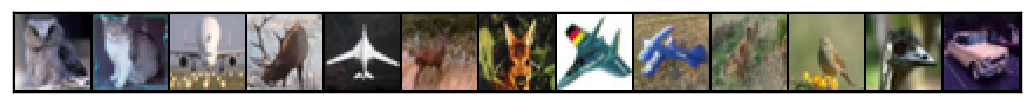

In [4]:
def get_pytorch_dataset(dataset, device, classes_to_keep=None):
  X, Y = [], []
  for x, y in dataset:
    if classes_to_keep is not None and y in classes_to_keep:
      X.append(torch.tensor(x))
      Y.append(y)
    elif classes_to_keep is None:
      X.append(torch.tensor(x))
      Y.append(y)
  X = torch.stack(X).to(device)
  Y = torch.tensor(Y).long().to(device)
  return TensorDataset(X, Y)

train_data = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_data, valid_data = random_split(train_data, [45000, 5000])

train_data = get_pytorch_dataset(train_data, DEVICE, classes_to_keep=[0,1,2,3,4])
valid_data = get_pytorch_dataset(valid_data, DEVICE, classes_to_keep=[0,1,2,3,4])
test_data = get_pytorch_dataset(test_data, DEVICE, classes_to_keep=[0,1,2,3,4])

train_dl = DataLoader(train_data, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_data, batch_size=1024, shuffle=False)
test_dl  = DataLoader(test_data, batch_size=1024, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Train size: {len(train_dl.dataset)}")
print(f"Valid size: {len(valid_dl.dataset)}")
print(f"Test size: {len(test_dl.dataset)}")

plot_samples(train_data)

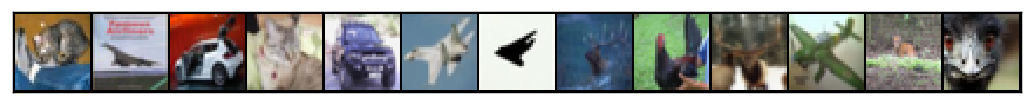

In [5]:
plot_samples(test_data)

# Get $\mathcal{D}_\text{ood}$

Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_1530055/966994739.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X.append(torch.tensor(x))


OOD size: 30000


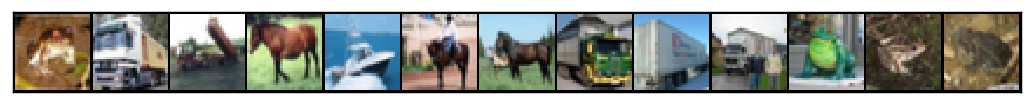

In [6]:
train_data = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_data = get_pytorch_dataset(train_data, DEVICE, classes_to_keep=[5,6,7,8,9])
test_data = get_pytorch_dataset(test_data, DEVICE, classes_to_keep=[5,6,7,8,9])

X_train, Y_train = train_data.tensors
X_test, Y_test = test_data.tensors

perturb_data = TensorDataset(torch.cat((X_train, X_test)), torch.cat((Y_train, Y_test)))

perturb_dl = DataLoader(perturb_data, batch_size=256, shuffle=True)

print(f"OOD size: {len(perturb_dl.dataset)}")

plot_samples(perturb_data)

# Fetch CIFAR100

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


/tmp/ipykernel_1530055/966994739.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X.append(torch.tensor(x))


Test size: 10000


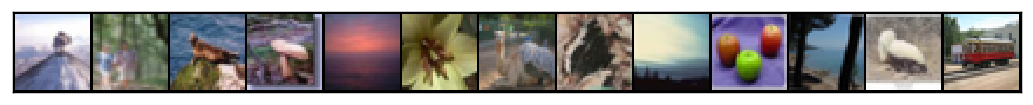

In [7]:
test_data_c100 = CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())

test_data_c100 = get_pytorch_dataset(test_data_c100, DEVICE)

test_dl_c100  = DataLoader(test_data_c100, batch_size=1024, shuffle=False)

print(f"Test size: {len(test_dl_c100.dataset)}")

plot_samples(test_data_c100)

# Utils

In [9]:
@torch.no_grad()
def get_acc(model, dl): # Eval without dropout
  model.eval()
  # model.set_sample(False)
  acc = []
  for X, y in dl:
    acc.append(torch.argmax(model(X), dim=1) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  model.train()
  # model.set_sample(True)
  return acc.item()


@torch.no_grad()
def get_ensemble_acc(models, dl): # Eval without dropout, eval the ensemble
  for model in models:
    model.eval()
    # model.set_sample(False)
  acc = []
  for X, y in dl:
    outs = [torch.softmax(model(X), dim=1) for model in models]
    outs = torch.stack(outs, dim=0).mean(dim=0)
    acc.append(torch.argmax(outs, dim=1) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  for model in models:
    model.train()
    # model.set_sample(True)
  return acc.item()


@torch.no_grad()
def get_probas_mcd(model, dl, num_samples=10, use_dropout=True):
  # return the proabilities for samples using MC-dropout (unless use_dropout=False)
  model.eval()
  # model.set_sample(use_dropout)
  probs = []
  for X, y in dl:
    outs = [model(X) for x in range(num_samples)]
    ps = [torch.softmax(out, dim=1) for out in outs]
    mean_ps = torch.stack(ps).mean(dim=0)
    probs.append(mean_ps)
  probs = torch.cat(probs)
  return probs


@torch.no_grad()
def get_probas_ensemble(models, dl):
  for model in models:
    model.eval()
    # model.set_sample(False)
  probs = []
  for X, y in dl:
    outs = [model(X) for model in models]
    ps = [torch.softmax(out, dim=1) for out in outs]
    mean_ps = torch.stack(ps).mean(dim=0)
    probs.append(mean_ps)
  probs = torch.cat(probs)
  return probs


def plot_hist(probas):
  fig, (ax) = plt.subplots(1,1,figsize=(3,3), dpi=110)

  ax.grid()

  ax.set_xlabel("largest probability")
  ax.set_ylabel("Number of datapoints")

  _ = ax.hist(probas, bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], linestyle='solid', color='g')
  ax.set_xlim(0, 1)

# Training utils

In [10]:
import torchvision.models as model_zoo
def dl_to_sampler(dl):
  dl_iter = iter(dl)
  def sample():
    nonlocal dl_iter
    try:
      return next(dl_iter)
    except StopIteration:
      dl_iter = iter(dl)
      return next(dl_iter)
  return sample

def m_f(num_classes=2):
    m = model_zoo.resnet18(pretrained=True)
    d = m.fc.in_features
    m.fc = nn.Linear(d, num_classes)
    return m.to(DEVICE)

def sequential_train(num_models, train_dl, valid_dl, perturb_dl, alpha=1, max_epoch=30,
                     use_diversity_reg=True, lr=0.2, weight_decay=1e-5, dropout=0.2, num_classes=2):
  seed_everything(41)
  models = [m_f(num_classes=num_classes) for _ in range(num_models)]

  stats = {f"m{i+1}": {"acc": [], "loss": [], "adv-loss": []} for i in range(len(models))}

  for m_idx, m in enumerate(models):

    for m_ in models[:m_idx]:
      m_.eval()
      # m.set_sample(False)

    opt = torch.optim.SGD(m.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay, nesterov=True)
    scheduler = torch.optim.lr_scheduler.CyclicLR(opt, 0, lr, step_size_up=(len(train_dl)*max_epoch)//2, mode='triangular', cycle_momentum=False)

    perturb_sampler = dl_to_sampler(perturb_dl)

    for epoch in range(max_epoch):
      for itr, (x, y) in enumerate(train_dl):
        (x_tilde,  _) = perturb_sampler()
        erm_loss = F.cross_entropy(m(x), y)

        if use_diversity_reg and m_idx != 0:
          adv_loss = []

          p_2 = torch.softmax(m(x_tilde), dim=1)
          p_2_1, max_idx = p_2.max(dim=1)
          p_2_0 = 1. - p_2_1

          with torch.no_grad():
            p_1_s = [torch.softmax(m_(x_tilde), dim=1) for m_ in models[:m_idx]]
            p_1_1_s = [p_1[torch.arange(len(p_1)), max_idx] for p_1 in p_1_s]
            p_1_0_s = [1. - p_1_1 for p_1_1 in p_1_1_s]

          for i in range(len(p_1_s)):
            al = (- torch.log(p_1_1_s[i] * p_2_0 + p_2_1 * p_1_0_s[i] +  1e-7)).mean()
            adv_loss.append(al)
        else:
          adv_loss = [torch.tensor([0]).to(DEVICE)]

        adv_loss = sum(adv_loss)/len(adv_loss)

        if use_diversity_reg and m_idx != 0:
          loss = erm_loss + alpha * adv_loss
        else:
          loss = erm_loss

        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()

        if (itr + epoch * len(train_dl)) % 200 == 0:
          itr_ = itr + epoch * len(train_dl)
          print_str = f"[m{m_idx+1}] {epoch}/{itr_} [train] loss: {erm_loss.item():.2f} adv-loss: {adv_loss.item():.2f} "
          stats[f"m{m_idx+1}"]["loss"].append((itr_, erm_loss.item()))
          stats[f"m{m_idx+1}"]["adv-loss"].append((itr_, adv_loss.item()))
          acc = get_acc(m, valid_dl)
          stats[f"m{m_idx+1}"]["acc"].append((itr_, acc))
          print_str += f" acc: {acc:.2f} "
          if itr_ != 0 and scheduler is not None:
            print_str += f"[lr] {scheduler.get_last_lr()[0]:.5f} "
          print(print_str)

        itr += 1

  stats['all_models'] = models

  return stats

# Train without D-BAT

In [11]:
stats = sequential_train(5, train_dl, valid_dl, perturb_dl, alpha=0.0,
                         max_epoch=20, use_diversity_reg=True, lr=0.1,
                         weight_decay=5e-4, dropout=0.2, num_classes=5)

/users/ug21/ashwingoyal/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/users/ug21/ashwingoyal/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[m1] 0/0 [train] loss: 1.85 adv-loss: 0.00  acc: 0.18 
[m1] 2/200 [train] loss: 0.36 adv-loss: 0.00  acc: 0.84 [lr] 0.02284 
[m1] 4/400 [train] loss: 0.28 adv-loss: 0.00  acc: 0.83 [lr] 0.04557 
[m1] 6/600 [train] loss: 0.15 adv-loss: 0.00  acc: 0.83 [lr] 0.06830 
[m1] 9/800 [train] loss: 0.09 adv-loss: 0.00  acc: 0.84 [lr] 0.09102 
[m1] 11/1000 [train] loss: 0.08 adv-loss: 0.00  acc: 0.82 [lr] 0.08625 
[m1] 13/1200 [train] loss: 0.10 adv-loss: 0.00  acc: 0.86 [lr] 0.06352 
[m1] 15/1400 [train] loss: 0.06 adv-loss: 0.00  acc: 0.87 [lr] 0.04080 
[m1] 18/1600 [train] loss: 0.00 adv-loss: 0.00  acc: 0.89 [lr] 0.01807 
[m2] 0/0 [train] loss: 1.88 adv-loss: 0.90  acc: 0.20 
[m2] 2/200 [train] loss: 0.33 adv-loss: 2.61  acc: 0.83 [lr] 0.02284 
[m2] 4/400 [train] loss: 0.31 adv-loss: 3.18  acc: 0.84 [lr] 0.04557 
[m2] 6/600 [train] loss: 0.22 adv-loss: 3.21  acc: 0.80 [lr] 0.06830 
[m2] 9/800 [train] loss: 0.20 adv-loss: 3.88  acc: 0.83 [lr] 0.09102 
[m2] 11/1000 [train] loss: 0.12 adv-loss: 

In [12]:
get_ensemble_acc(stats['all_models'], test_dl)

0.9009999632835388

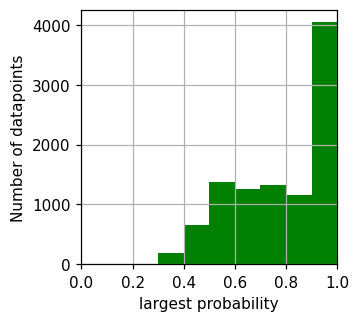

In [13]:
probas_ensemble_c100 = get_probas_ensemble(stats['all_models'], test_dl_c100)
probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
plot_hist(probas_ensemble_c100)

Ensemble Size = 1

0.8829999566078186


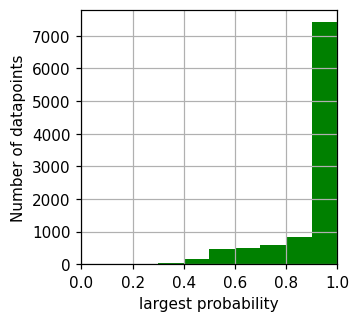

In [14]:
print(get_ensemble_acc(stats['all_models'][:1], test_dl))
probas_ensemble_c100 = get_probas_ensemble(stats['all_models'][:1], test_dl_c100)
probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
plot_hist(probas_ensemble_c100)

Ensemble Size = 2

0.894599974155426


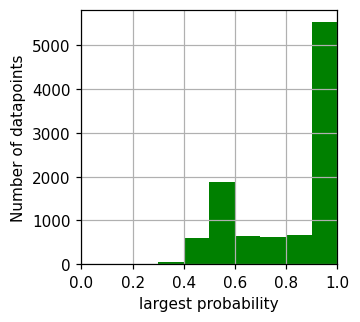

In [15]:
print(get_ensemble_acc(stats['all_models'][:2], test_dl))
probas_ensemble_c100 = get_probas_ensemble(stats['all_models'][:2], test_dl_c100)
probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
plot_hist(probas_ensemble_c100)

Ensemble Size = 3

0.8981999754905701


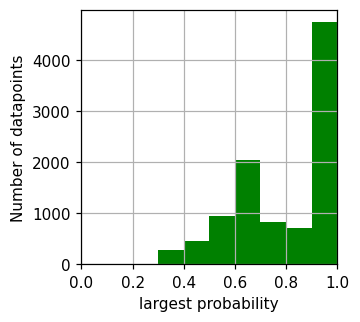

In [16]:
print(get_ensemble_acc(stats['all_models'][:3], test_dl))
probas_ensemble_c100 = get_probas_ensemble(stats['all_models'][:3], test_dl_c100)
probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
plot_hist(probas_ensemble_c100)

Ensemble Size 4


0.9007999897003174


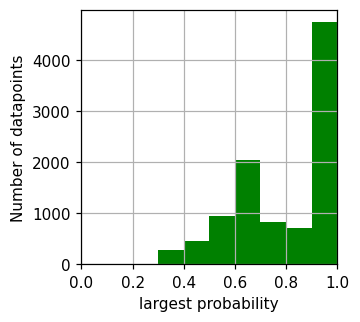

In [17]:
print(get_ensemble_acc(stats['all_models'][:4], test_dl))
probas_ensemble_c100 = get_probas_ensemble(stats['all_models'][:3], test_dl_c100)
probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
plot_hist(probas_ensemble_c100)

# Train with D-BAT

In [18]:
stats = sequential_train(5, train_dl, valid_dl, perturb_dl, alpha=0.0045,
                         max_epoch=20, use_diversity_reg=True, lr=0.1,
                         weight_decay=5e-4, dropout=0.2,num_classes=5)

[m1] 0/0 [train] loss: 1.85 adv-loss: 0.00  acc: 0.18 
[m1] 2/200 [train] loss: 0.36 adv-loss: 0.00  acc: 0.84 [lr] 0.02284 
[m1] 4/400 [train] loss: 0.28 adv-loss: 0.00  acc: 0.83 [lr] 0.04557 
[m1] 6/600 [train] loss: 0.15 adv-loss: 0.00  acc: 0.83 [lr] 0.06830 
[m1] 9/800 [train] loss: 0.09 adv-loss: 0.00  acc: 0.84 [lr] 0.09102 
[m1] 11/1000 [train] loss: 0.08 adv-loss: 0.00  acc: 0.82 [lr] 0.08625 
[m1] 13/1200 [train] loss: 0.10 adv-loss: 0.00  acc: 0.86 [lr] 0.06352 
[m1] 15/1400 [train] loss: 0.06 adv-loss: 0.00  acc: 0.87 [lr] 0.04080 
[m1] 18/1600 [train] loss: 0.00 adv-loss: 0.00  acc: 0.89 [lr] 0.01807 
[m2] 0/0 [train] loss: 1.88 adv-loss: 0.90  acc: 0.20 
[m2] 2/200 [train] loss: 0.30 adv-loss: 2.38  acc: 0.85 [lr] 0.02284 
[m2] 4/400 [train] loss: 0.20 adv-loss: 3.11  acc: 0.76 [lr] 0.04557 
[m2] 6/600 [train] loss: 0.20 adv-loss: 2.94  acc: 0.81 [lr] 0.06830 
[m2] 9/800 [train] loss: 0.14 adv-loss: 3.09  acc: 0.83 [lr] 0.09102 
[m2] 11/1000 [train] loss: 0.14 adv-loss: 

In [19]:
get_ensemble_acc(stats['all_models'], test_dl)

0.9023999571800232

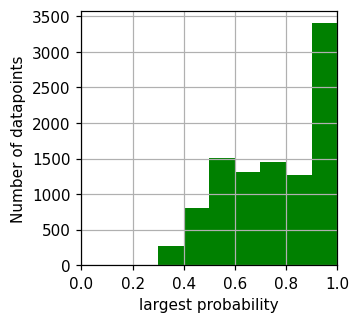

In [20]:
probas_ensemble_c100 = get_probas_ensemble(stats['all_models'], test_dl_c100)
probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
plot_hist(probas_ensemble_c100)

Ensemble Size = 1

0.8829999566078186


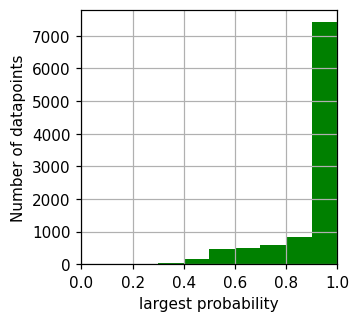

In [21]:
print(get_ensemble_acc(stats['all_models'][:1], test_dl))
probas_ensemble_c100 = get_probas_ensemble(stats['all_models'][:1], test_dl_c100)
probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
plot_hist(probas_ensemble_c100)

Ensemble Size = 2

0.8971999883651733


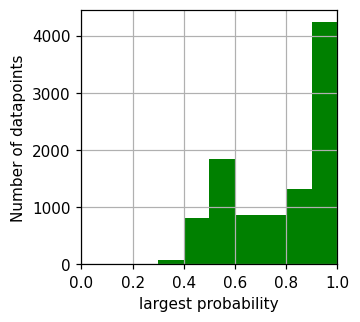

In [22]:
print(get_ensemble_acc(stats['all_models'][:2], test_dl))
probas_ensemble_c100 = get_probas_ensemble(stats['all_models'][:2], test_dl_c100)
probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
plot_hist(probas_ensemble_c100)

Ensemble Size = 3

0.8973999619483948


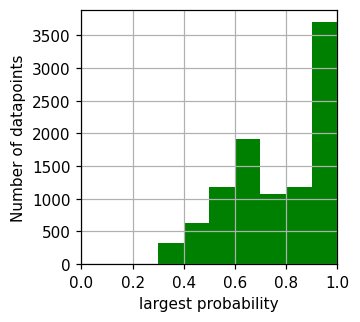

In [23]:
print(get_ensemble_acc(stats['all_models'][:3], test_dl))
probas_ensemble_c100 = get_probas_ensemble(stats['all_models'][:3], test_dl_c100)
probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
plot_hist(probas_ensemble_c100)

Ensemble size = 4

0.9017999768257141


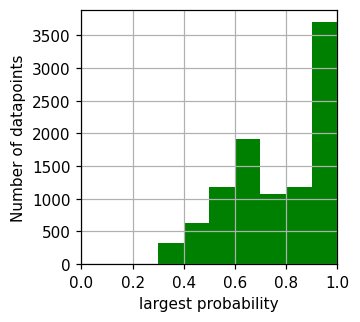

In [24]:
print(get_ensemble_acc(stats['all_models'][:4], test_dl))
probas_ensemble_c100 = get_probas_ensemble(stats['all_models'][:3], test_dl_c100)
probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
plot_hist(probas_ensemble_c100)